In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [1]:
# survival analysis, lifelines library
import lifelines

In [3]:
# survival analysis, scikit-survival library
from sksurv.nonparametric import kaplan_meier_estimator

# Analyze survival of changed lines

For each commit in commit sharings in the DevGPT dataset, compute how many of changed lines (post-image lines, i.e. added lines in unified diff) survived to present, that is to `HEAD` revision.

The calculations were done using the [`compute_changes_survival.py`](../src/data/compute_changes_survival.py) script.

Below there is result of running some previous version of this script (excerpt):
```
$ python scripts/data/compute_changes_survival.py \
    data/interim/commit_sharings_df.csv data/repositories_download_status.json \
    data/interim/commit_sharings_changes_survival_df.csv \
    data/interim/commit_sharings_lines_survival_df.csv
Start time: 2023-11-22 23:08:02.088391 ==============================
Reading commit sharings data from 'data/interim/commit_sharings_df.csv'...
Loading info about cloned repos from 'data/repositories_download_status.json'...
Processing (694, 18) commit sharings data...
[...]
commit: 694it [01:41,  6.83it/s]
Skipped 5 rows because of an error
Created 76 of GitRepo objects
Lines survival stats:
  130298 / 169469 = 76.89% lines survived; 39171 did not
  orig commit metadata: 169221 from blame,   248 from repo = 169469 total
  last commit metadata: 169444 from blame,    25 from repo = 169469 total
  next commit metadata:  38929 from blame,   242 from repo =  39171 total
  515 from repo total
Creating dataframe with augmentation data from 694 records...
Creating dataframe with line survival data from 169469 records...
Merging (694, 18) with (694, 10) dataframes on 'Sha'...
Writing (696, 27) of augmented commit sharings data
  to 'data/interim/commit_sharings_changes_survival_df.csv'
Writing (169469, 16) of changed lines survival data
  to 'data/interim/commit_sharings_lines_survival_df.csv'
End time: 2023-11-22 23:09:45.434304 ================================
Function main() {} took 103.3454 seconds = 0:01:43.345356
```

In [3]:
df = pd.read_csv('../data/interim/commit_sharings_changes_survival_df.csv')

In [4]:
df.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message',
       'AuthorAt', 'CommitAt', 'NumberOfChatgptSharings',
       'TotalNumberOfPrompts', 'TotalTokensOfPrompts', 'TotalTokensOfAnswers',
       'NumberOfConversations', 'ModelGPT4', 'ModelGPT3_5', 'ModelOther',
       'Status404', 'author_timestamp', 'committer_timestamp', 'n_parents',
       'is_merged_HEAD', 'number_of_commits_from_HEAD', 'error',
       'change_lines_survived', 'change_lines_total',
       'min_died_committer_timestamp'],
      dtype='object')

In [5]:
df['RepoName'].value_counts()

RepoName
tisztamo/Junior                          575
pbrudny/jobsforit-de                      16
hoshotakamoto/banzukesurfing              15
kevinveenbirkenbach/computer-playbook      4
bh679/MindfulAI2.0                         4
                                        ... 
larrywright/larrywright.me                 1
REReal8/CCWorldPlatform                    1
saimonmoore/jira-tools                     1
aifenxiang19/AIChat                        1
openai/evals                               1
Name: count, Length: 76, dtype: int64

In [9]:
# it is counting commits
df['RepoLanguage'].value_counts()

RepoLanguage
CSS                 614
HTML                 19
Python               14
Dockerfile            8
JavaScript            6
Shell                 5
C                     4
Cython                4
Batchfile             3
Java                  2
Lua                   2
Jinja                 1
C#                    1
Jupyter Notebook      1
Pascal                1
Go                    1
EJS                   1
GAML                  1
Name: count, dtype: int64

In [18]:
df_sel = df[[
    'RepoName', 'RepoLanguage', 'URL', 'Sha',
    'is_merged_HEAD', 'error', 'change_lines_survived', 'change_lines_total',
    #'min_died_committer_timestamp',
]]
df_sel

,RepoName,RepoLanguage,URL,Sha,is_merged_HEAD,error,change_lines_survived,change_lines_total
0,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/fa335...,fa335cf2ec447d00f8e94b54a8b463725b92947c,True,False,0.0,13.0
1,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/0dfc4...,0dfc4385b723060e1e6a21da17a952bd908084ff,True,False,2.0,119.0
2,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/811d0...,811d09acdca361c81281c7d71587ebdbd8437453,True,False,3.0,35.0
3,bh679/MindfulAI2.0,CSS,https://github.com/bh679/MindfulAI2.0/commit/e...,e4a8c0fe3adfefb5922315c5b9df3c9cc4c0cff6,True,False,1.0,1.0
4,4lejandrito/fetchbook,JavaScript,https://github.com/4lejandrito/fetchbook/commi...,11725c1a23503f31f7b7cd13188c8d9e30e822a9,True,False,89.0,129.0
...,...,...,...,...,...,...,...,...
691,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,d0a54935a6e665bfaaa858adb6afc42b231707fe,True,False,16.0,42.0
692,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,90e1d68ddc8d3a2caa076ee4d423484bf0a742f3,True,False,11.0,33.0
693,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,63b2ab90b0b138e509e87efad59fd72b414d0133,True,False,27.0,106.0
694,openai/evals,JavaScript,https://github.com/openai/evals/commit/771dce8...,771dce83870cb2e6ab6e99b1c96682de5658c210,True,False,12.0,12.0


In [11]:
df_sel[['is_merged_HEAD', 'error']].describe()

,is_merged_HEAD,error
count,696,696
unique,1,2
top,True,False
freq,696,691


In [13]:
df_sel['error'].value_counts()

error
False    691
True       5
Name: count, dtype: int64

This means that there were 5 cases where there was an error.<br>
In all cases the commit was merged into HEAD (it was most likely, as it is how it was found).

In [19]:
# we can skip those cases when there was an error
df_sel = df_sel[df_sel['error'] == False]

In [21]:
df_sel.loc[:,'change_lines_survived_perc'] = 100.0*df_sel['change_lines_survived']/df_sel['change_lines_total']

In [22]:
df_sel.describe()

,change_lines_survived,change_lines_total,change_lines_survived_perc
count,691.000000,691.000000,688.000000
mean,188.920405,245.610709,50.418306
std,2955.876717,2966.866913,44.196029
min,0.000000,0.000000,0.000000
25%,2.000000,41.000000,4.894180
50%,18.000000,79.000000,33.333333
75%,76.500000,129.500000,98.048643
max,77301.000000,77344.000000,100.000000


In [23]:
s_change_lines_sum = df_sel[['change_lines_survived', 'change_lines_total']].sum()
s_change_lines_sum

change_lines_survived    130544.0
change_lines_total       169717.0
dtype: float64

In [24]:
s_change_lines_sum['change_lines_survived']/s_change_lines_sum['change_lines_total']

0.769186351396737

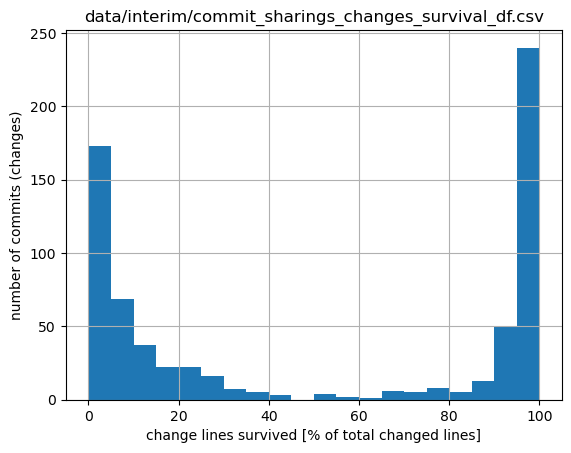

In [39]:
fig, ax = plt.subplots()
df_sel['change_lines_survived_perc'].hist(ax=ax, bins=20)
ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('number of commits (changes)')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

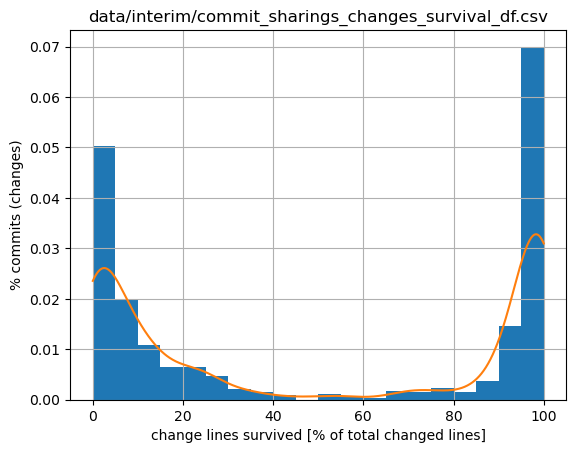

In [55]:
fig, ax = plt.subplots()

df_sel['change_lines_survived_perc'].hist(ax=ax, bins=20, density=True, grid=True)
df_sel['change_lines_survived_perc'].plot.kde(bw_method=0.1, ind=np.linspace(0, 100, num=1000, endpoint=True), grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('% commits (changes)')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

/tmp/ipykernel_1120371/110446166.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_sel[['change_lines_survived', 'change_lines_total']].hist(ax=ax, range=(0,300), density=True)


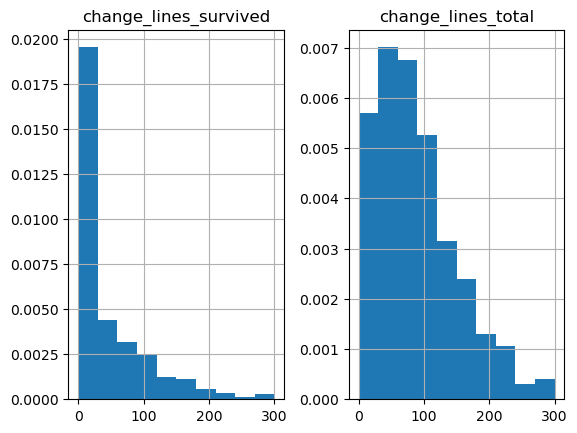

In [29]:
fig, ax = plt.subplots()
df_sel[['change_lines_survived', 'change_lines_total']].hist(ax=ax, range=(0,300), density=True)
ax.set_xlabel('change lines (cut off)')
ax.set_ylabel('% number of commits')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

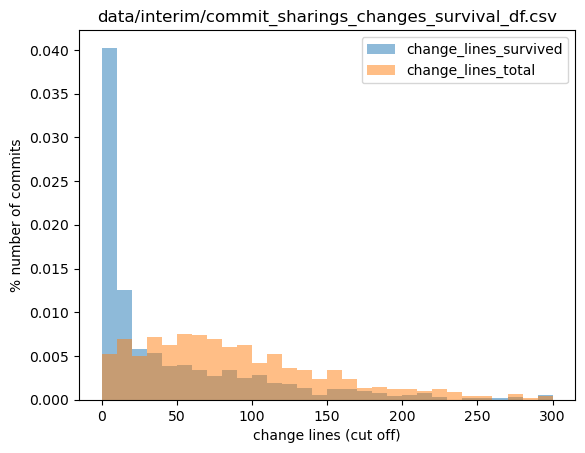

In [37]:
ax = df_sel[['change_lines_survived', 'change_lines_total']].plot.hist(bins=30, alpha=0.5, range=(0,300), density=True)
ax.set_xlabel('change lines (cut off)')
ax.set_ylabel('% number of commits')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

## With outlier tisztamo/Junior repo removed

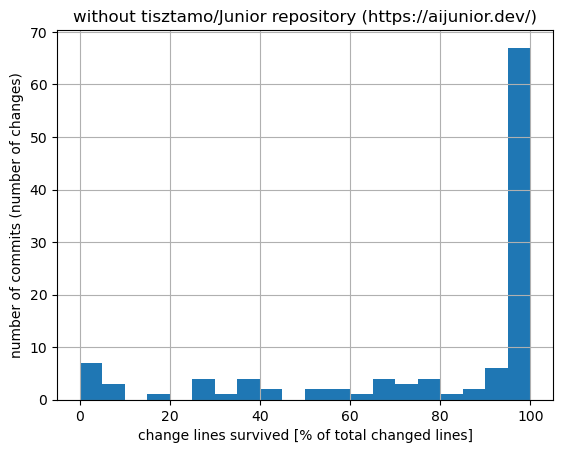

In [25]:
fig, ax = plt.subplots()

df_subsel = df_sel[df_sel['RepoName'] != 'tisztamo/Junior']

df_subsel['change_lines_survived_perc'].hist(ax=ax, bins=20, grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('number of commits (number of changes)')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

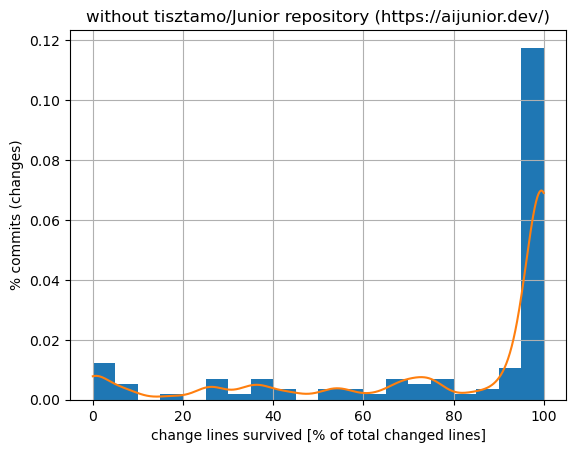

In [56]:
fig, ax = plt.subplots()

df_subsel = df_sel[df_sel['RepoName'] != 'tisztamo/Junior']

df_subsel['change_lines_survived_perc'].hist(ax=ax, bins=20, density=True, grid=True)
df_subsel['change_lines_survived_perc'].plot.kde(bw_method=0.1, ind=np.linspace(0, 100, num=1000, endpoint=True), grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('% commits (changes)')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

In [26]:
df_subsel.describe()

,change_lines_survived,change_lines_total,change_lines_survived_perc
count,117.000000,117.000000,114.000000
mean,772.307692,804.769231,78.596199
std,7152.919448,7159.427417,32.436033
min,0.000000,0.000000,0.000000
25%,10.000000,14.000000,67.248062
50%,27.000000,39.000000,98.453966
75%,87.000000,114.000000,100.000000
max,77301.000000,77344.000000,100.000000


In [27]:
s_subsel_sum = df_subsel[['change_lines_survived', 'change_lines_total']].sum()
s_subsel_sum

change_lines_survived    90360.0
change_lines_total       94158.0
dtype: float64

In [28]:
print("Change lines that survived, as totals of all change lines")
print(f"{100.0*s_subsel_sum['change_lines_survived']/s_subsel_sum['change_lines_total']} % (without tisztamo/Junior)")
print(f"{100.0*s_change_lines_sum['change_lines_survived']/s_change_lines_sum['change_lines_total']} % (all)")

Change lines that survived, as totals of all change lines
95.96635442554005 % (without tisztamo/Junior)
76.9186351396737 % (all)


# Survival analysis of lines

**Survival analysis** is a branch of statistics for analyzing the expected duration of time until one event occurs, such as death in biological organisms and failure in mechanical systems. This topic is called _reliability theory_ or _reliability analysis_ in engineering, _duration analysis_ or _duration modelling_ in economics, and _event history analysis_ in sociology.

In our case we are interested in **lifetime** of _changes_ that were created with the help of ChatGPT.  In the case of this part of analysis, we analyze commits sharings from DevGPT dataset, that is commits where commit message includes `https://chat.openai.com/share/` link.

Let's define what the terms used in survival analysis mean in this analysis:
- an _event_ ("death") is the change vanishing, or rather the **change line** introduced by commit from the DevGPT dataset vanishing from code
- the _beginning of observation_ ("birth") is creation of the commit from the DevGPT dataset
- _censoring_ (_censored observation_) occurs when the change line did survive until the date the repository was cloned, and is still present in the code in HEAD in the project's repository

> **NOTE** that currently we do not take into consideration and into account whether a given line of change was taken from ChatGPT answer or not.

In [4]:
lines_df = pd.read_csv('../data/interim/commit_sharings_lines_survival_df.csv')

/tmp/ipykernel_824954/1010409278.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  lines_df = pd.read_csv('../data/interim/commit_sharings_lines_survival_df.csv')


In [5]:
lines_df.columns

Index(['RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'next_commit', 'next_filename',
       'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp'],
      dtype='object')

In [6]:
lines_df.dtypes

RepoName                     object
Sha                          object
Sha_filename                 object
Sha_lineno                    int64
last_commit                  object
last_filename                object
last_lineno                   int64
line                         object
next_commit                  object
next_filename                object
Sha_author_timestamp          int64
Sha_committer_timestamp       int64
last_author_timestamp         int64
last_committer_timestamp      int64
next_author_timestamp       float64
next_committer_timestamp    float64
dtype: object

In [5]:
# counting lines, in commits, in repositories
lines_df['RepoName'].value_counts()

RepoName
p3ob7o/Speak                             77344
tisztamo/Junior                          75559
hoshotakamoto/banzukesurfing              5802
Buildstarted/linksfordevs                 3378
pbrudny/jobsforit-de                      1375
                                         ...  
TurboWarp/extensions                         4
jordanbell2357/resume                        4
The-Poolz/EthSmartContractIO                 3
eshreyareddy/prompting-zomato-reviews        1
SupraSensum/TOP-project-etch-a-sketch        1
Name: count, Length: 70, dtype: int64

In [39]:
print(f"There are {len(lines_df['RepoName'].unique())} unique GitHub repositories ('RepoName')")
for repo in lines_df['RepoName'].value_counts().index:
    print(f"  https://github.com/{repo}")

There are 70 unique GitHub repositories ('RepoName')
  https://github.com/p3ob7o/Speak
  https://github.com/tisztamo/Junior
  https://github.com/hoshotakamoto/banzukesurfing
  https://github.com/Buildstarted/linksfordevs
  https://github.com/pbrudny/jobsforit-de
  https://github.com/jimfergusondev/ChatGPTBuildsDelphiPolygonIOApiCalls
  https://github.com/multi-imcookie/cookies
  https://github.com/labd/terraform-provider-storyblok
  https://github.com/mgalgs/conf-files
  https://github.com/naomiajacobs/ColorPaletteReactTutorial
  https://github.com/damus-io/nostrdb
  https://github.com/eodinzov94/IsraFit
  https://github.com/Karunamon/pixlbot
  https://github.com/HolyBarrel/CPP-Udemy-Course
  https://github.com/elliotrichh/github1
  https://github.com/waylon620/GPT-tutor
  https://github.com/grnpin/textbox
  https://github.com/kevinveenbirkenbach/computer-playbook
  https://github.com/cwerdna19/ghoul-traders
  https://github.com/mgalgs/github-pr-fetch
  https://github.com/4lejandrito/f

In [41]:
lines_df['RepoName'].value_counts().loc[['zzzeek/sqlalchemy','sqlalchemy/sqlalchemy']]

RepoName
zzzeek/sqlalchemy        124
sqlalchemy/sqlalchemy    124
Name: count, dtype: int64

In [44]:
lines_df[lines_df['RepoName'] == 'sqlalchemy/sqlalchemy']['has_next'].value_counts()

has_next
False    123
True       1
Name: count, dtype: int64

In [47]:
lines_df.groupby('RepoName')['has_next'].sum().sort_values()

RepoName
winksaville/scripts                           0
openai/evals                                  0
naomiajacobs/ColorPaletteReactTutorial        0
The-Poolz/EthSmartContractIO                  0
poki/netlib                                   0
                                          ...  
grnpin/textbox                              162
multi-imcookie/cookies                      172
hoshotakamoto/banzukesurfing                215
Buildstarted/linksfordevs                  2112
tisztamo/Junior                           35375
Name: has_next, Length: 70, dtype: int64

In [50]:
s_has_next = lines_df.groupby('RepoName')['has_next'].sum()
s_has_next[s_has_next > 0].sort_values()

RepoName
Atulaya123/reddit-next13-prisma-sql                     1
Cissucalris9/cuemaker2                                  1
SupraSensum/TOP-project-etch-a-sketch                   1
VoxturTijmen/Experimental                               1
jordanbell2357/resume                                   1
dbt-labs/docs.getdbt.com                                1
zzzeek/sqlalchemy                                       1
larrywright/larrywright.me                              1
sqlalchemy/sqlalchemy                                   1
temporalio/temporal                                     1
DuarteSerrao/TS                                         2
kevinveenbirkenbach/cli-gnome-extension-manager         2
lightward/mechanic-tasks                                3
elouanb7/MSPR-B3-Deploiement-appli                      4
labd/terraform-provider-storyblok                       4
damus-io/nostrdb                                        5
GillyRabutTsurwa/su-2025-rest-api                       5
knowl

In [9]:
lines_df.loc[:,'Sha_committer_time']  = pd.to_datetime(lines_df['Sha_committer_timestamp'], unit='s')
lines_df.loc[:,'last_committer_time'] = pd.to_datetime(lines_df['last_committer_timestamp'], unit='s')
lines_df.loc[:,'next_committer_time'] = pd.to_datetime(lines_df['next_committer_timestamp'], unit='s')

In [10]:
lines_df.describe()

,Sha_lineno,last_lineno,Sha_author_timestamp,Sha_committer_timestamp,last_author_timestamp,last_committer_timestamp,next_author_timestamp,next_committer_timestamp,Sha_committer_time,last_committer_time,next_committer_time
count,169469.000000,169469.000000,1.694690e+05,1.694690e+05,1.694690e+05,1.694690e+05,3.917100e+04,3.917100e+04,169469,169469,39171
mean,784.948038,885.959403,1.690249e+09,1.690250e+09,1.691990e+09,1.691990e+09,1.691299e+09,1.691299e+09,2023-07-25 01:46:45.950439680,2023-08-14 05:18:07.480571904,2023-08-06 05:21:20.915115520
min,1.000000,1.000000,1.685180e+09,1.685180e+09,1.685182e+09,1.685182e+09,1.685221e+09,1.685221e+09,2023-05-27 09:39:31,2023-05-27 09:59:37,2023-05-27 21:04:22
25%,29.000000,29.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.690007e+09,1.690007e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-07-22 06:22:26
50%,93.000000,95.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691228e+09,1.691228e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-05 09:32:21
75%,585.000000,626.000000,1.691532e+09,1.691532e+09,1.697911e+09,1.697911e+09,1.692173e+09,1.692173e+09,2023-08-08 22:08:19,2023-10-21 18:02:34,2023-08-16 08:11:02
max,15242.000000,15129.000000,1.696945e+09,1.696945e+09,1.699798e+09,1.699798e+09,1.699471e+09,1.699471e+09,2023-10-10 13:44:49,2023-11-12 14:09:08,2023-11-08 19:12:42
std,1607.755683,1880.820448,2.240694e+06,2.241184e+06,4.352591e+06,4.352596e+06,1.747924e+06,1.747994e+06,NaN,NaN,NaN


The presence of not N/A **`next_commit`** will be used as _'event observed'_ column

In [11]:
lines_df.loc[:, 'has_next'] = lines_df['next_commit'].notna()
lines_df['has_next'].value_counts()

has_next
False    130298
True      39171
Name: count, dtype: int64

In [12]:
lines_df.loc[:, 'survival_duration'] = lines_df['next_committer_time'] - lines_df['Sha_committer_time']

In [13]:
lines_df['survival_duration']

0        44 days 17:27:13
1        44 days 17:27:13
2        44 days 17:27:13
3         0 days 00:16:42
4        44 days 17:27:13
               ...       
169464                NaT
169465                NaT
169466                NaT
169467                NaT
169468                NaT
Name: survival_duration, Length: 169469, dtype: timedelta64[ns]

In [14]:
lines_df.loc[:, 'survival_duration_days'] = lines_df['survival_duration'].dt.total_seconds()/(60*60*24)
lines_df['survival_duration_days']

0         44.727234
1         44.727234
2         44.727234
3          0.011597
4         44.727234
            ...    
169464          NaN
169465          NaN
169466          NaN
169467          NaN
169468          NaN
Name: survival_duration_days, Length: 169469, dtype: float64

In [15]:
lines_df['survival_duration_days'].describe()

count    39171.000000
mean         5.725990
std         15.639174
min          0.000012
25%          0.014734
50%          0.071563
75%          1.001898
max        111.494988
Name: survival_duration_days, dtype: float64

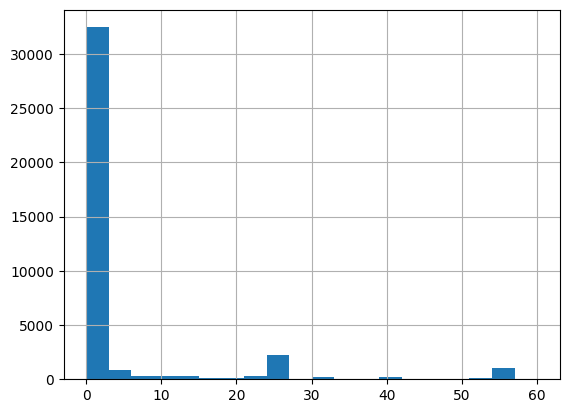

In [16]:
ax = lines_df['survival_duration_days'].hist(bins=20, range=(0,60))

In [17]:
lines_df.loc[:, 'unchanged_duration'] = lines_df['last_committer_time'] - lines_df['Sha_committer_time']
lines_df['unchanged_duration'].describe()

count                        169469
mean     20 days 03:31:21.530132354
std      34 days 23:55:34.512940153
min                 0 days 00:00:00
25%                 0 days 00:44:23
50%                 0 days 00:44:23
75%                35 days 07:57:45
max               161 days 03:57:24
Name: unchanged_duration, dtype: object

In [18]:
lines_df.loc[:, 'unchanged_duration_days'] = lines_df['unchanged_duration'].dt.total_seconds()/(60*60*24)
lines_df['unchanged_duration_days']

0         44.707662
1         44.707662
2         44.707662
3          0.007095
4         44.707662
            ...    
169464     2.065972
169465     2.065972
169466     2.065972
169467     2.065972
169468     2.065972
Name: unchanged_duration_days, Length: 169469, dtype: float64

In [19]:
lines_df.loc[ lines_df['has_next'], 'observed_duration'] = lines_df['survival_duration']
lines_df.loc[~lines_df['has_next'], 'observed_duration'] = lines_df['unchanged_duration']
lines_df['observed_duration']

0        44 days 17:27:13
1        44 days 17:27:13
2        44 days 17:27:13
3         0 days 00:16:42
4        44 days 17:27:13
               ...       
169464    2 days 01:35:00
169465    2 days 01:35:00
169466    2 days 01:35:00
169467    2 days 01:35:00
169468    2 days 01:35:00
Name: observed_duration, Length: 169469, dtype: timedelta64[ns]

In [20]:
lines_df.loc[:, 'observed_duration_days'] = lines_df['observed_duration'].dt.total_seconds()/(60*60*24)
lines_df['observed_duration_days']

0         44.727234
1         44.727234
2         44.727234
3          0.011597
4         44.727234
            ...    
169464     2.065972
169465     2.065972
169466     2.065972
169467     2.065972
169468     2.065972
Name: observed_duration_days, Length: 169469, dtype: float64

## Kaplan-Meier estimation of survival function

In [21]:
kmf_l = lifelines.KaplanMeierFitter()

In [22]:
T = lines_df['observed_duration_days']
E = lines_df['has_next']

In [23]:
kmf_l.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 169469 total observations, 130298 right-censored observations>

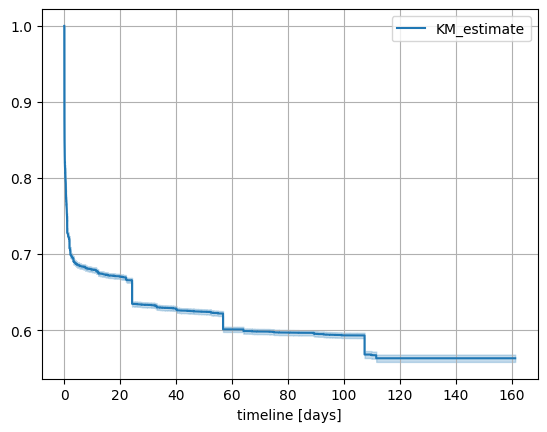

In [24]:
ax = kmf_l.plot_survival_function(grid=True)
ax.set_xlabel('timeline [days]')

plt.show()

In [25]:
table_l = lifelines.utils.survival_table_from_events(T, E)
print(table_l.head())

          removed  observed  censored  entrance  at_risk
event_at                                                
0.000000      794         0       794    169469   169469
0.000012        6         6         0         0   168675
0.000868       13        13         0         0   168669
0.001100        1         1         0         0   168656
0.001181        2         2         0         0   168655


In [26]:
# For less visual clutter, you may want to subsample to less than 25 individuals.
#ax = lifelines.plotting.plot_lifetimes(T, event_observed=E)

#plt.show()

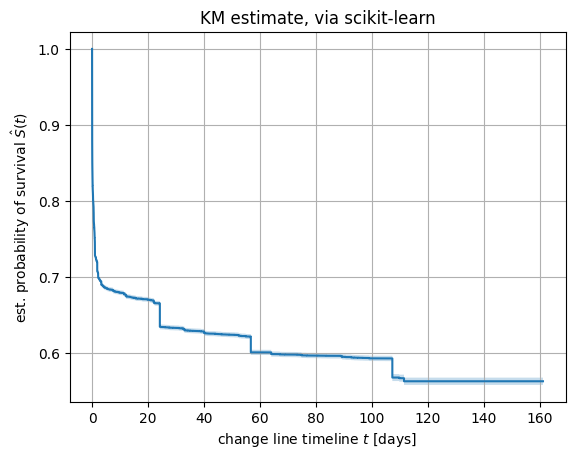

In [33]:
# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#The-Survival-Function

time, survival_prob, conf_int = kaplan_meier_estimator(
    E, T, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
#plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn")
plt.grid()

plt.show()

## KM esitimation, with outlier tisztamo/Junior repo removed

In [27]:
lines_df_subsel = lines_df[lines_df['RepoName'] != 'tisztamo/Junior']
lines_df_subsel.describe()

,Sha_lineno,last_lineno,Sha_author_timestamp,Sha_committer_timestamp,last_author_timestamp,last_committer_timestamp,next_author_timestamp,next_committer_timestamp,Sha_committer_time,last_committer_time,next_committer_time,survival_duration,survival_duration_days,unchanged_duration,unchanged_duration_days,observed_duration,observed_duration_days
count,93910.000000,93910.000000,9.391000e+04,9.391000e+04,9.391000e+04,9.391000e+04,3.796000e+03,3.796000e+03,93910,93910,3796,3796,3796.000000,93910,93910.000000,93910,93910.000000
mean,646.243318,677.192706,1.689021e+09,1.689023e+09,1.689332e+09,1.689332e+09,1.691785e+09,1.691785e+09,2023-07-10 20:55:19.488627456,2023-07-14 10:58:25.440187648,2023-08-11 20:14:07.839041280,4 days 12:58:39.669125395,4.540737,3 days 14:03:05.951560004,3.585486,3 days 15:32:38.833446917,3.647672
min,1.000000,1.000000,1.685180e+09,1.685180e+09,1.685182e+09,1.685182e+09,1.685221e+09,1.685221e+09,2023-05-27 09:39:31,2023-05-27 09:59:37,2023-05-27 21:04:22,0 days 00:00:01,0.000012,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000
25%,55.000000,56.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691543e+09,1.691543e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-09 01:09:17,0 days 13:58:06,0.582014,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
50%,178.000000,189.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691619e+09,1.691619e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-09 22:11:03,1 days 00:02:44,1.001898,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
75%,686.000000,738.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691718e+09,1.691718e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-11 01:39:34.750000128,1 days 02:06:12,1.087639,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
max,15242.000000,15129.000000,1.696945e+09,1.696945e+09,1.699798e+09,1.699798e+09,1.699471e+09,1.699471e+09,2023-10-10 13:44:49,2023-11-12 14:09:08,2023-11-08 19:12:42,97 days 10:41:04,97.445185,161 days 03:57:24,161.164861,161 days 03:57:24,161.164861
std,1037.704465,1105.617920,1.325254e+06,1.327972e+06,2.260476e+06,2.260531e+06,2.375265e+06,2.375745e+06,NaN,NaN,NaN,12 days 12:46:07.190316380,12.532028,16 days 08:17:06.635682171,16.345216,16 days 10:37:47.920336546,16.442916


In [28]:
T_sel = lines_df_subsel['observed_duration_days']
E_sel = lines_df_subsel['has_next']

E_sel.value_counts()

has_next
False    90114
True      3796
Name: count, dtype: int64

In [29]:
kmf_l.fit(T_sel, event_observed=E_sel)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 93910 total observations, 90114 right-censored observations>

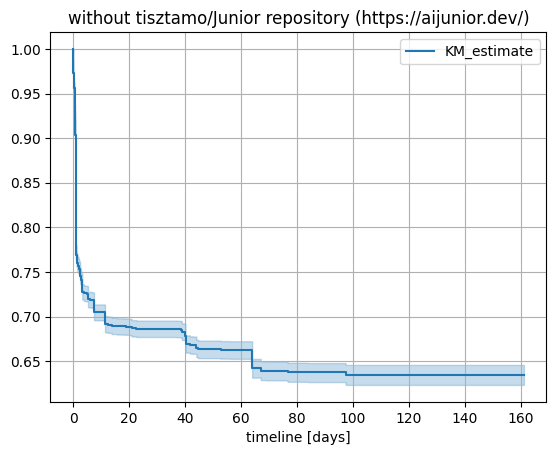

In [30]:
ax = kmf_l.plot_survival_function(grid=True)
ax.set_xlabel('timeline [days]')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

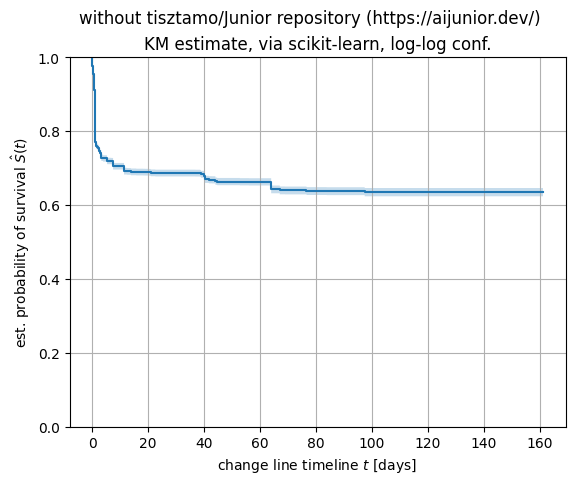

In [34]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    E_sel, T_sel, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn, log-log conf.")
plt.suptitle('without tisztamo/Junior repository (https://aijunior.dev/)')
plt.grid()

plt.show()

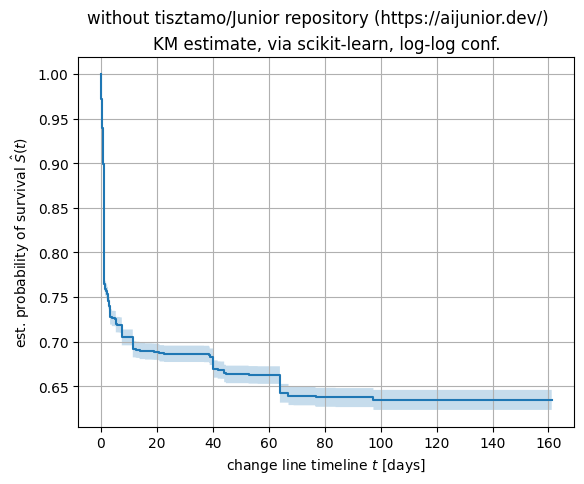

In [35]:
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
#plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn, log-log conf.")
plt.suptitle('without tisztamo/Junior repository (https://aijunior.dev/)')
plt.grid()

plt.show()